### Reliability across layers

In [21]:
from pathlib import Path
import os
import sys
import random
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from palettable.matplotlib import Inferno_20 as ColMap
from fmri_decoder.data import SurfaceData
from src.stats import Bootstrap
from src.data import Data
from src.config import SUBJECTS, SESSION, DIR_BASE, N_LAYER
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

SESS = "VASO"

In [30]:
class Reliability:
    """Compute between-session correlation of a contrast sampled at a specific layer."""

    def __init__(self, subj, sess, frac=0.1):
        self.subj = subj
        self.sess = sess
        self.frac = frac # fraction of data randomly selected

    def get_label(self):
        # get label and hemisphere
        data = Data(self.subj, [])
        surf_data = SurfaceData(data.file_layer, None, data.file_label)

        label_left = surf_data.load_label_intersection("lh")
        label_right = surf_data.load_label_intersection("rh")

        hemi = np.zeros(len(label_left)+len(label_right))
        hemi[len(label_left):] = 1
        label = np.append(label_left, label_right)

        return label, hemi

    def get_contrast(self, hemi, day, layer):
        file_in = (
            Path(DIR_BASE) 
            / self.subj 
            / "odc/results/Z/sampled" 
            / f"Z_all_left_right_{self.sess}{SESSION[self.subj][self.sess][day]}" 
            / f"{hemi}.Z_all_left_right_{self.sess}{SESSION[self.subj][self.sess][day]}_layer_{layer}.mgh"
        )
        return nb.load(file_in).get_fdata().flatten()

    def get_data(self, layer):
        label, hemi = self.get_label()
        data1 = np.zeros_like(hemi)
        data2 = np.zeros_like(hemi)
        data1[hemi == 0] = self.get_contrast("lh", 0, layer)[label[hemi == 0]]
        data1[hemi == 1] = self.get_contrast("rh", 0, layer)[label[hemi == 1]]
        data2[hemi == 0] = self.get_contrast("lh", 1, layer)[label[hemi == 0]]
        data2[hemi == 1] = self.get_contrast("rh", 1, layer)[label[hemi == 1]]

        # get subset of data for statistics
        ndata = int(self.frac * len(data1))
        ind = np.arange(len(data1))
        random.shuffle(ind)
        sample_0 = data1[ind[:ndata]]
        sample_1 = data2[ind[:ndata]]
        
        return sample_0, sample_1

    def corr(self, layer):
        sample_0, sample_1 = self.get_data(layer)
        r, _ = spearmanr(sample_0, sample_1)  # spearman
        return r

In [35]:
# compute r-value
# array: (N_LAYER, N_SUBJECT)
r_val = np.zeros((N_LAYER, len(SUBJECTS)))
for i in range(N_LAYER):
    for j, subj in enumerate(SUBJECTS):
        rel = Reliability(subj=subj, sess=SESS)
        r_val[i, j] = rel.corr(i)

# compute confidence intervals
ci_low = []
ci_high = []
for i in range(N_LAYER):
    boot = Bootstrap(r_val[i,:])
    low, high = boot.confidence_interval()
    ci_low.append(low)
    ci_high.append(high)

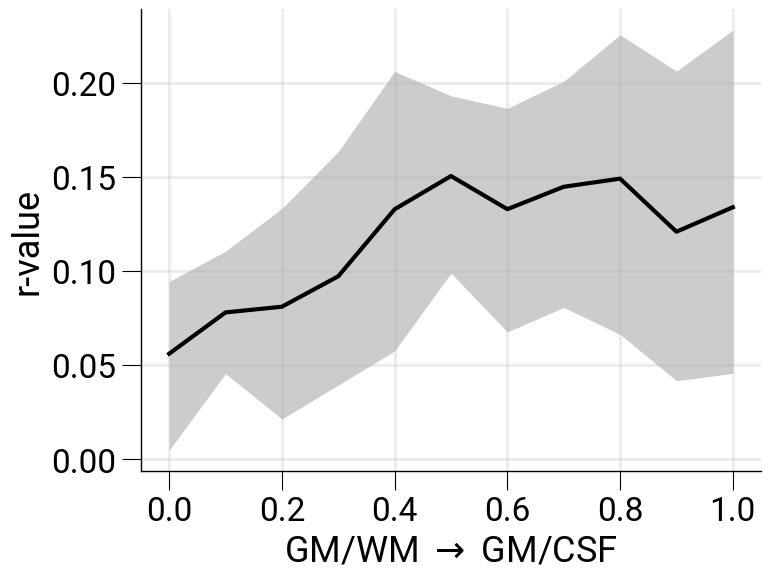

In [36]:
fig, ax = plt.subplots()
color = ColMap.hex_colors
x = np.linspace(0, 1, N_LAYER)
ax.plot(x, np.mean(r_val, axis=1), color=color[0], linestyle="-", lw=3)
ax.fill_between(x, ci_low, ci_high, color=color[0], alpha=0.2, lw=0)
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("r-value")
file_out = f"/data/pt_01880/reliability_layer_{SESS}.svg"
#fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")